# Acceptance Rejection Sampling

Author: Fred J. Hickernell + ChatGPT

This notebook provides examples of generating IID samples via the acceptance-rejection method.

#### Some LaTeX macros (hidden in math mode, will not render correctly in VS Code)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\vU}{\boldsymbol{U}}
\newcommand{\vzero}{\boldsymbol{0}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cn}{\mathcal{N}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\cgp}{\mathcal{G}\!\mathcal{P}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Prob}{\mathbb{P}}
\newcommand{\bbone}{\mathbb{1}}
\newcommand{\disc}{\operatorname{disc}}
\newcommand{\norm}[2]{{\left \lVert #1 \right \rVert}_{#2}}
$

#### Run this notebook in Juypter with the `conda qmcpy` environment or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/MATH565Fall2025/blob/main/notebooks/GeneratingRandomVectors.ipynb?flush_cache=true)

In [1]:
if "google.colab" in str(get_ipython()):
    print("⚡Note: Setup here can take a few minutes.")
    !apt-get -y install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    %pip install git+https://github.com/QMCSoftware/QMCSoftware.git@develop
    !git clone https://github.com/QMCSoftware/MATH565Fall2025.git
    %cd MATH565Fall2025/notebooks
    print("\n✅ Colab setup complete.")
    print("   For faster performance, please install the qmcpy environment locally.")

### Import needed packages and initialize some parameters

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import qmcpy as qp
import time
from IPython.display import display, Markdown
import sys
from pathlib import Path
REPO_ROOT = Path.cwd().resolve().parent  # one level up from notebooks/
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
import nbviz as nb
nb.init(use_tex=True)                     # styling, Tol cycle, CSS, interactive plotting
colors = nb.TOL_BRIGHT                    # e.g., colors["cyan"]
TINY = nb.TINY

## Acceptance-Rejection Sampling
The code below implements acceptance-rejection setting.  We have 
- a target (unnormalized) PDF, $\varrho$
- a proposal PDF, $\varrho_Z$
- a constant $M$ such that $\varrho(z) \le M \varrho_Z(z)$
A sample, $Z\sim \varrho_Z$ and $U \sim \mathcal{U}[0,1]$, yields a new sample from the target distribution if
$$
U \le \varrho(Z)/[M\varrho_Z(Z)] \qquad \textsf{or equivalently} \qquad \log(U) + \log(M) + \log(\varrho_Z(Z)) - \log(\varrho(Z)) \le 0
$$

### Normal sampling using an exponential distribution
If $(U_1, U_2, U_3) \sim \mathcal{U}[0,1]^3$, then
- $\varrho(z) = \exp(-z^2/2) \ \forall z \ge 0$ is the unnormalized target density with normalizing constant $\sqrt{2/\pi}$
- $\varrho_Z(z) = \exp(-z) \ \forall z \ge 0$, $-\log(U_1) \sim \text{Exp}(1)$
- $(U_2 < 0.5) \sim \mathcal{U}\{0,1\}$, which can be used to determine the sign
- $U_3$ can be used to decide whether to accept
Note that
$$
1 \le \exp((z-1)^2/2) \implies  \underbrace{\exp(-z^2/2)}_{\varrho(z)} \le \underbrace{\exp(1/2)}_M \underbrace{\exp(-z)}_{\varrho_Z(z)}
$$

The following code generates normal random numbers via exponential random numbers

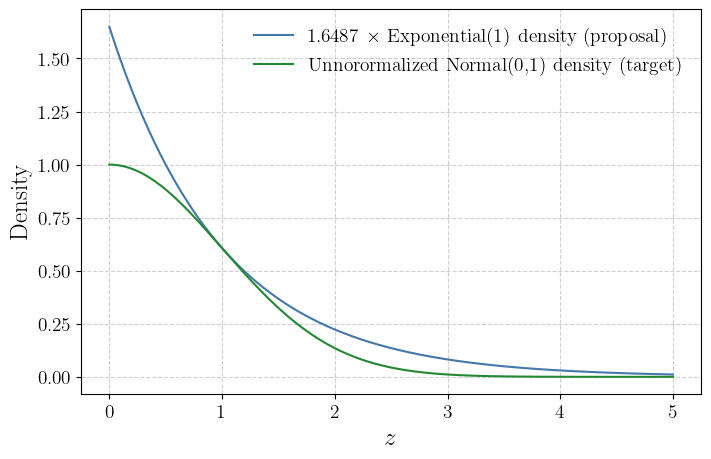

In [3]:
x = np.linspace(0, 5, 500)
density_exponential = np.exp(-x)
unnormalized_normal = np.exp(-x*x/2)
M = np.exp(0.5)  #You may change this to anything no less than 
plt.figure(figsize=(8, 5))
plt.plot(x, M*density_exponential, label=rf"{M:.4f} $\times$ Exponential(1) density (proposal)", color=colors["blue"])
plt.plot(x, unnormalized_normal, label="Unnorormalized Normal(0,1) density (target)", color=colors["green"])
plt.xlabel("$z$")
plt.ylabel("Density")
#plt.title("Exponential vs Normal Density (x ≥ 0)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


<div class="highlight-note">
Note:
<ul>
  <li> This $M$ is chosen so that $M \exp(z)$ lies just above the unnormalized normal density and touches at sone point</li>
  <li> You can make $M$ larger (and the algorithm will be less efficient), but not smaller</li>
</ul></div>

In [4]:
def ar_standard_normal_exp1(n, #number of samples required
                            M = np.exp(0.5)
                           ):
    """
    Acceptance–rejection sampling for N(0,1) using an exponential (λ=1) proposal
    (magnitude from Exp(1), sign from a coin flip).

    Proposal construction:
      - U1 ~ Unif(0,1),  Z = -log(U1)        # Exp(1)
      - U2 ~ Unif(0,1),  S = ±1 with prob 1/2
      - U3 ~ Unif(0,1): accept if U3 <= p(Y)/(M q(Y))
    Target:
      p(z) = exp(-z^2/2) on [0,infty) is unnormalized density with normalizing constant sqrt(2/pi)
    Proposal:
      q(z) = exp(-z)
    Envelope constant:
      M = exp(1/2) ≈ 1.65
      Expected acceptance ≈ 1/[exp(1/2)*sqrt(2/pi)] ≈ 0.76
    """
    rng = np.random.default_rng(None)
    M_min = np.exp(0.5)
    if M < M_min:
        warnings.warn(f"M = {M:.4f} is too small; resetting to exp(0.5) ≈ {M_min:.4f}")
        M = M_min
    log_M = np.log(M)
    exp_accept_rate = np.sqrt(np.pi/2)/M  #1/(M * the normalizing constant)
    samples = np.empty(n, dtype=float)
    n_acc = 0
    n_prop_total = 0
    accepted_raw_total = 0
    while n_acc < n:
        B = max(50,int((n - n_acc) * 1.2/exp_accept_rate)) #estimated needed batch size, 1.2 is an inflation factor
        U1 = rng.random(B)  #will be used for the exponential
        U2 = rng.random(B)  #will be used for the sign
        U3 = rng.random(B)  #will be used for the decision
        Z = -np.log(U1)  #exponential random variable, some of which we will accept
        log_p = -0.5 * Z**2  #log of unnormalized target density
        log_q = -Z   #log of proposal density  
        accept = np.log(U3) + log_M + log_q - log_p <= 0  #acceptance criterion
        num_new = int(np.sum(accept))  #how many are accepted
        accepted_raw_total += num_new  # count all accepts, even if discarded
        if num_new > 0:
            take = min(num_new, n - n_acc)  #which ones to accept and save, since we may not need all
            samples[n_acc:n_acc+take] = Z[accept][:take] * np.where(U2[accept][:take] < 0.5, -1.0, 1.0)  #take the accepted and apply a random sign
            n_acc += take
        n_prop_total += B
            
    info = {
        "accepted": n_acc,
        "accepted_raw": accepted_raw_total,
        "proposed": n_prop_total,
        "accept_rate_effective": n_acc / n_prop_total,
        "accept_rate_intrinsic": accepted_raw_total / n_prop_total,
        "M": M,
        "expected_accept_rate": exp_accept_rate,
    }
    return samples, info

The following demo compares the acceptance-rejection sampler to numpy's built-in sampler

AR accept rate (intrinsic): 0.7608 (theory ≈ 0.7602)
AR accept rate (effective): 0.6335
Time (AR)     : 0.0080 s
Time (NumPy)  : 0.0008 s


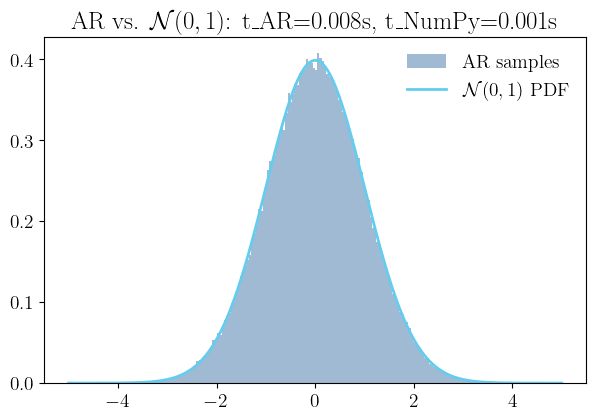

In [5]:
# --- Acceptance–Rejection sampler for N(0,1) using an Exp(1) proposal mirrored by a random sign ---
from time import perf_counter
# --- Demo: draw samples, plot histogram + pdf, and time vs SciPy/NumPy ---
n = 200_000

# 1) Acceptance-Rejection timing
t0 = perf_counter()
ar_samples, ar_info = ar_standard_normal_exp1(n, M=M)
t_ar = perf_counter() - t0

# 2) NumPy timing (fast baseline)
t0 = perf_counter()
numpy_samples = np.random.default_rng(None).standard_normal(n)
t_numpy = perf_counter() - t0

print(f"AR accept rate (intrinsic): {ar_info['accept_rate_intrinsic']:.4f} "
      f"(theory ≈ {ar_info['expected_accept_rate']:.4f})")
print(f"AR accept rate (effective): {ar_info['accept_rate_effective']:.4f}")
print(f"Time (AR)     : {t_ar:.4f} s")
print(f"Time (NumPy)  : {t_numpy:.4f} s")

# Plot: histogram of AR samples + true N(0,1) pdf
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.hist(ar_samples, bins="auto", density=True, alpha=0.5, label="AR samples")
x = np.linspace(-5, 5, 1000)
ax.plot(x, sp.stats.norm.pdf(x), lw=2, label=rf"$\mathcal{{N}}(0,1)$ PDF")
ax.set_title(rf"AR vs. $\mathcal{{N}}(0,1)$:  t_AR={t_ar:.3f}s, t_NumPy={t_numpy:.3f}s")
ax.legend(loc = "upper right");

### Acceptance-rejection sampler
Here is code for a general acceptance-rejection sampler.  We need to supply logarithms of the target and proposal densities because logarithms are more numerically stable.

In [6]:
def accept_reject(
    log_target_density,        # log of unnormalized target density, takes array (n,d) → array (n,)
    proposal_sampler,          # proposal sampler, proposal_sampler(n, rng) → array (n,d)
    log_prop_density=None,     # log proposal density, same vectorization as log_target_density. Optional.
    M=None,                    # constant ≥ sup_x target_density(x)/q(x). Required if log_prop_density is given.
    n_samples=1000,            # number of samples requested
    pilot_n=100,               # number of pilot samples to estimate acceptance rate
    batch_max=50000,           # maximum batch size, do not want to run out of memory
    max_proposals=None,        # maxmum number of proposals
    rng=None
):
    """
    Generic accept–reject sampling with batch sizing based on a pilot run.

    Modes:
    1) General AR (log_prop_density and M provided):
         Accept with prob = exp(log_target_density(x) - log_prop_density(x)) / M.
    2) Unit-peak mode (log_prop_density=None, M=None):
         Assumes 0 <= exp(log_target_density(x)) <= 1 and proposal is uniform on its support.
         Accept with prob = exp(log_target_density(x)).
    """
    rng = np.random.default_rng(rng)

    unit_peak_mode = (log_prop_density is None)
    if unit_peak_mode:
        if M is not None:
            raise ValueError("Do not provide M in unit-peak mode.")
        mode = "unit-peak"
    else:
        if M is None or M <= 0:
            raise ValueError("Must provide positive M in general AR mode.")
        mode = "general"

    accepted = []
    proposed_total = 0
    batches = 0

    def propose_and_accept(n_prop):
        """Draw proposals and apply accept–reject test."""
        x = proposal_sampler(n_prop, rng)   # shape (n_prop, d)
        if x.ndim != 2:
            raise ValueError("proposal_sampler must return a 2D array of shape (n, d).")

        lp = log_target_density(x)

        if unit_peak_mode:
            # acceptance prob = exp(log_target_density(x)), assumed in [0,1]
            a = np.exp(np.minimum(lp, 0.0))
        else:
            lq = log_prop_density(x)
            a = np.exp(lp - lq) / M
            a = np.minimum(a, 1.0)

        # Safety: zero-out non-finite probabilities
        a = np.where(np.isfinite(a) & (a >= 0), a, 0.0)

        u = rng.random(size=n_prop)
        acc = (u < a)
        return x, acc

    # --- Pilot run ---
    x_pilot, acc_pilot = propose_and_accept(pilot_n)
    pilot_acc_rate = float(acc_pilot.mean()) if pilot_n > 0 else 0.0
    accepted.append(x_pilot[acc_pilot])
    proposed_total += pilot_n
    batches += 1

    # Early exit if pilot already gave enough
    have = sum(chunk.shape[0] for chunk in accepted)
    if have >= n_samples:
        out = np.concatenate(accepted, axis=0)[:n_samples]
        info = dict(
            proposed=proposed_total,
            accepted=n_samples,
            pilot_accept_rate=pilot_acc_rate,
            final_accept_rate=n_samples / proposed_total,
            batches=batches,
            mode=mode,
            M=(None if unit_peak_mode else float(M)),
        )
        return out, info

    remaining = n_samples - have
    use_estimate = pilot_acc_rate > 0

    # --- Main loop ---
    while remaining > 0:
        if use_estimate:
            # overshoot by 10% for safety
            n_prop = int(np.ceil(1.10 * remaining / pilot_acc_rate))
        else:
            n_prop = batch_max

        n_prop = min(n_prop, batch_max)
        if (max_proposals is not None) and (proposed_total + n_prop > max_proposals):
            n_prop = max(0, max_proposals - proposed_total)
            if n_prop == 0:
                break

        x_batch, acc_batch = propose_and_accept(n_prop)
        accepted.append(x_batch[acc_batch])
        proposed_total += n_prop
        batches += 1
        remaining = n_samples - sum(chunk.shape[0] for chunk in accepted)

    got = sum(chunk.shape[0] for chunk in accepted)
    if got == 0:
        raise RuntimeError(
            "No samples were accepted. In general AR mode, check that your bound constant M is large enough. "
            "In unit-peak mode, check that your unnormalized density is between 0 and 1."
        )

    samples = np.concatenate(accepted, axis=0)
    if samples.shape[0] >= n_samples:
        samples = samples[:n_samples]

    info = dict(
        proposed=proposed_total,
        accepted=samples.shape[0],
        pilot_accept_rate=pilot_acc_rate,
        final_accept_rate=samples.shape[0] / proposed_total if proposed_total > 0 else 0.0,
        batches=batches,
        mode=mode,
        M=(None if unit_peak_mode else float(M)),
    )
    return samples, info

### A banana shaped unnormalized density
The following is an example of a nontrivial densit for which it would be difficult to use a quantile function to generate random samples

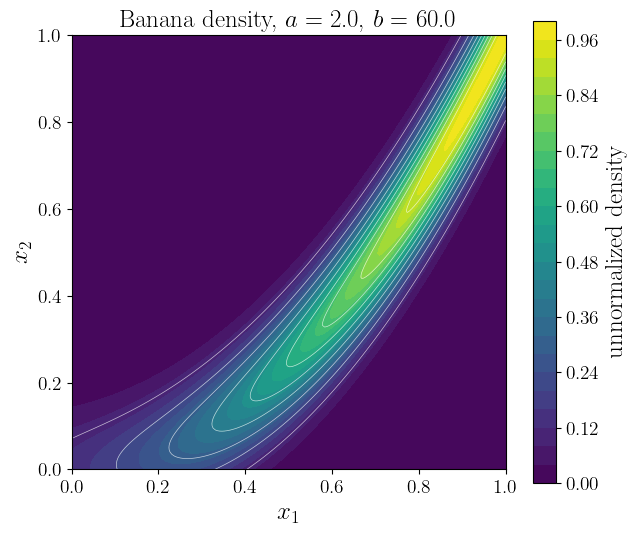

In [7]:
def log_banana(points, a=2.0, b=60.0):  # Example of a banana shaped target on [0,1]^2
    x, y = points[:,0], points[:,1]
    inside = (x>=0)&(x<=1)&(y>=0)&(y<=1)
    output = np.full(points.shape[0], -np.inf)
    output[inside] = -a*(1-x[inside])**2 - b*(y[inside]-x[inside]**2)**2
    return output

#Plot the banana
a = 2.
b = 60.
def plot_banana(a=a, b=b, n_grid=200):
    xs = np.linspace(0, 1, n_grid)
    ys = np.linspace(0, 1, n_grid)
    X, Y = np.meshgrid(xs, xs)
    pts = np.column_stack([X.ravel(), Y.ravel()])
    Z = np.exp(log_banana(pts, a=a, b=b)).reshape(X.shape)  #take the exponential of the log banana
    fig, ax = plt.subplots(figsize=(7,6))
    cf = ax.contourf(X, Y, Z, levels=30, cmap="viridis")
    cs = ax.contour(X, Y, Z, levels=10, colors="white", linewidths=0.5, alpha=0.7)
    ax.set_aspect('equal')
    fig.colorbar(cf, ax=ax, label="unnormalized density")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(f"Banana density, $a=$ {a}, $b=$ {b}")
    return ax

plot_banana(a=a, b=b);

{'proposed': 86630, 'accepted': 10000, 'pilot_accept_rate': 0.11, 'final_accept_rate': 0.11543345261456771, 'batches': 3, 'mode': 'unit-peak', 'M': None}


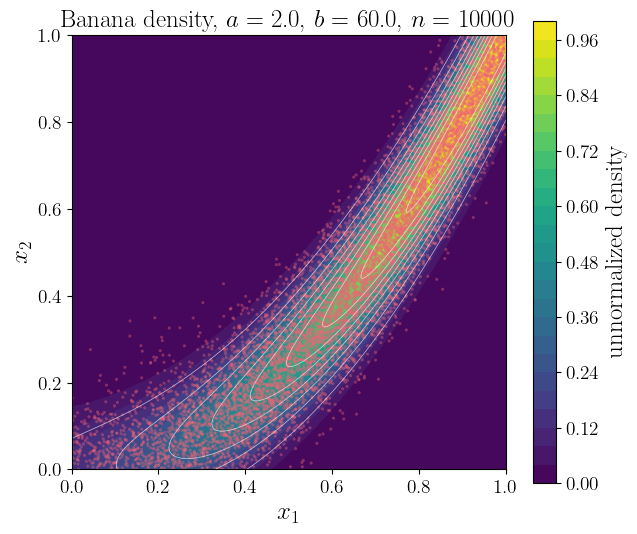

In [8]:
def sampler_uniform_01(d, n, rng=None):  #the uniform sampler to 
    rng = np.random.default_rng(rng)
    return rng.random((n,d))   # uniform on [0,1]^2

#Run the acceptance-rejection sampler
#Note that the uniform density proposal always lies above the target
n = 10_000
samples, info = accept_reject(
    log_target_density = lambda z: log_banana(z, a=a, b=b),
    proposal_sampler = lambda n, rng: sampler_uniform_01(2,n),
    log_prop_density = None,
    M = None,
    n_samples = n
)

print(info)
marker_size = 5
ax = plot_banana(a=a, b=b)
ax.scatter(samples[:,0], samples[:,1], s=marker_size, c=colors["red"], alpha=0.4, edgecolor="none")
ax.set_title(f"Banana density, $a=$ {a}, $b=$ {b}, $n=$ {n}");